<a href="https://colab.research.google.com/github/geexe/thai-cat-image-classification/blob/main/thai_cat_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [2]:
# Clone the repository
!git clone https://github.com/geexe/thai-cat-image-classification.git

Cloning into 'thai-cat-image-classification'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 320 (delta 2), reused 313 (delta 1), pack-reused 0
Receiving objects: 100% (320/320), 32.86 MiB | 33.41 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
# Navigate to the specific folder
# %cd thai-cat-image-classification/Image

# List the contents of the directory
import os
print(os.listdir())

['.config', 'thai-cat-image-classification', 'sample_data']


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# For image resizing
import cv2 as cv
print( f"OpenCV {cv.__version__}\n" )
import wandb

OpenCV 4.8.0



In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(2233)
tf.random.set_seed(3031)

In [4]:
base_dir = '/content/thai-cat-image-classification/Image'

# Image Augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Ensure this is set
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [5]:
!wandb login 872265a615a7284a38f47af24b872eaee0dfcfa6

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
# Choose Base Model and Number of Epochs
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_epochs = 20

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="thai-cat-cnn",

    # track hyperparameters and run metadata
    config={
    #"learning_rate": 0.02,
    "architecture": base_model.name,
    "dataset": "custom",
    "epochs": num_epochs,
    }
)

94668760/94668760 [==============================] - 1s 0us/step


wandb: Currently logged in as: thanyakorn-h (thanyakorn-h-NIDA). Use `wandb login --relogin` to force relogin


In [8]:
# Freeze base model layers
base_model.trainable = False

# Add custom layers
num_custom_classes = 3
current_model = models.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D((1, 1)),
    tf.keras.layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_custom_classes, activation='softmax')  # Replace with your number of classes
])
# current_model.summary()

# Compile the model
current_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback to save models and weights
save_weights_only = False
save_dir = '/content/thai-cat-image-classification/saved_model/'

if save_weights_only:
  checkpoint_filepath = save_dir + base_model.name + "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.weights.h5"
else:
  checkpoint_filepath = save_dir + base_model.name + "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=save_weights_only,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                verbose = 1,
                                                                save_best_only=True )

"# Training loop\nfor epoch in range(num_epochs):\n    # Train the model\n    history = current_model.fit(\n      train_generator,\n      steps_per_epoch=train_generator.samples // train_generator.batch_size,\n      validation_data=validation_generator,\n      validation_steps=validation_generator.samples // validation_generator.batch_size,\n      callbacks=[model_checkpoint_callback]\n    )\n\n    # Log metrics to wandb\n    wandb.log({\n        'model_name': base_model.name,\n        'epoch': epoch + 1,\n        'train_loss': history.history['loss'][0],\n        'train_accuracy': history.history['accuracy'][0],\n        'val_loss': history.history['val_loss'][0],\n        'val_accuracy': history.history['val_accuracy'][0]\n    })"

In [11]:
from wandb.integration.keras import WandbCallback

wandb_callback = WandbCallback(
    monitor="val_loss", verbose=0, mode="auto", save_weights_only=(False),
    log_weights=(False), log_gradients=(False), save_model=(True),
    training_data=None, validation_data=None, labels=None, predictions=36,
    generator=None, input_type=None, output_type=None, log_evaluation=(False),
    validation_steps=None, class_colors=None, log_batch_frequency=None,
    log_best_prefix="best_", save_graph=(True), validation_indexes=None,
    validation_row_processor=None, prediction_row_processor=None,
    infer_missing_processors=(True), log_evaluation_frequency=0,
    compute_flops=(False)
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [12]:
history = current_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback, wandb_callback]
)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 20.2954 - accuracy: 0.4952
Epoch 1: val_loss improved from inf to 2.72216, saving model to /content/thai-cat-image-classification/saved_model/resnet50v2bestmodel_epoch001_valloss2.72.keras


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240702_074157-n8if0ao9/files/model-best)... Done. 2.4s


7/7 [==============================] - 101s 15s/step - loss: 20.2954 - accuracy: 0.4952 - val_loss: 2.7222 - val_accuracy: 0.9062
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 4.5697 - accuracy: 0.8304
Epoch 2: val_loss improved from 2.72216 to 1.54425, saving model to /content/thai-cat-image-classification/saved_model/resnet50v2bestmodel_epoch002_valloss1.54.keras


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240702_074157-n8if0ao9/files/model-best)... Done. 5.3s


7/7 [==============================] - 101s 15s/step - loss: 4.5697 - accuracy: 0.8304 - val_loss: 1.5443 - val_accuracy: 0.9062
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 2.8217 - accuracy: 0.8798
Epoch 3: val_loss did not improve from 1.54425
7/7 [==============================] - 55s 8s/step - loss: 2.8217 - accuracy: 0.8798 - val_loss: 3.6965 - val_accuracy: 0.8438
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 1.9906 - accuracy: 0.9135
Epoch 4: val_loss improved from 1.54425 to 0.01032, saving model to /content/thai-cat-image-classification/saved_model/resnet50v2bestmodel_epoch004_valloss0.01.keras


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240702_074157-n8if0ao9/files/model-best)... Done. 2.4s


7/7 [==============================] - 89s 14s/step - loss: 1.9906 - accuracy: 0.9135 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - ETA: 0s - loss: 1.4181 - accuracy: 0.9375
Epoch 5: val_loss improved from 0.01032 to 0.00039, saving model to /content/thai-cat-image-classification/saved_model/resnet50v2bestmodel_epoch005_valloss0.00.keras


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240702_074157-n8if0ao9/files/model-best)... Done. 2.2s


7/7 [==============================] - 91s 13s/step - loss: 1.4181 - accuracy: 0.9375 - val_loss: 3.8860e-04 - val_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - ETA: 0s - loss: 2.0877 - accuracy: 0.9375
Epoch 6: val_loss did not improve from 0.00039
7/7 [==============================] - 53s 8s/step - loss: 2.0877 - accuracy: 0.9375 - val_loss: 2.2330 - val_accuracy: 0.9375
Epoch 7/20
7/7 [==============================] - ETA: 0s - loss: 1.4371 - accuracy: 0.9279
Epoch 7: val_loss did not improve from 0.00039
7/7 [==============================] - 55s 8s/step - loss: 1.4371 - accuracy: 0.9279 - val_loss: 0.4318 - val_accuracy: 0.9375
Epoch 8/20
7/7 [==============================] - ETA: 0s - loss: 1.2465 - accuracy: 0.9231
Epoch 8: val_loss did not improve from 0.00039
7/7 [==============================] - 48s 7s/step - loss: 1.2465 - accuracy: 0.9231 - val_loss: 0.6266 - val_accuracy: 0.9375
Epoch 9/20
7/7 [==============================] - ETA: 0s - loss: 1.16

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240702_074157-n8if0ao9/files/model-best)... Done. 2.2s


7/7 [==============================] - 103s 15s/step - loss: 0.8898 - accuracy: 0.9471 - val_loss: 5.0661e-06 - val_accuracy: 1.0000
Epoch 20/20
7/7 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.9760
Epoch 20: val_loss did not improve from 0.00001
7/7 [==============================] - 59s 8s/step - loss: 0.4091 - accuracy: 0.9760 - val_loss: 2.4941 - val_accuracy: 0.8750


## **Not used below**

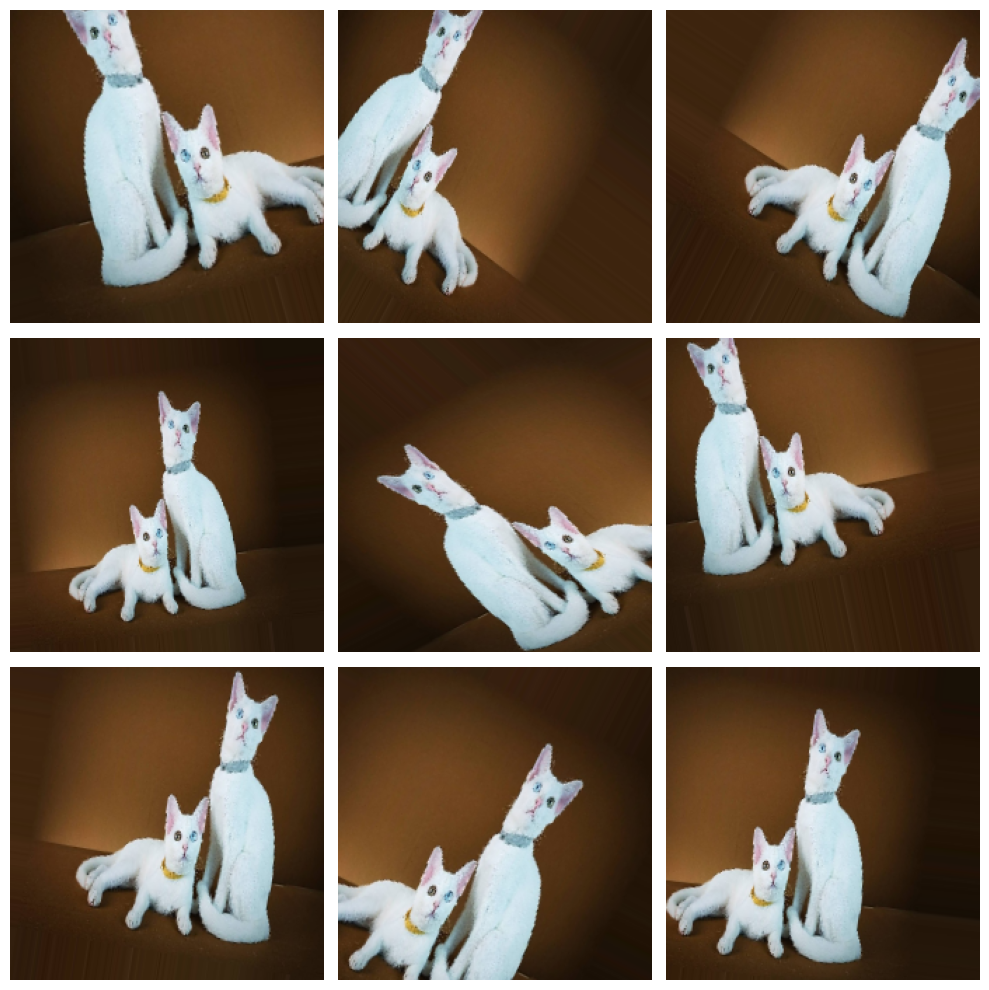

In [ ]:
# Show Augmented Images

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

img_path = '/content/thai-cat-image-classification/Image/class1/class1-1.jpg'  # Replace with your image path
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Generate augmented images
augmented_images = datagen.flow(x, batch_size=1)

# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    batch = augmented_images.next()
    img = batch[0]
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def my_imagenet_decode_predictions( preds, top=5 ):
    """
    This function is adapted from https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
    The adaptation is done so that ImageNet's class indices (0-999) are included in the function's outputs.

    Arguments:
        preds (numpy array): a batch of ImageNet's prediction outputs
        top (int): only decode 'top' classes with maximum scores

    Return a tuple of:
        Output[0]: a dict of { class_index:class_name } regarding the whole ImageNet dataset
        Output[1]: a 4D tuple of (class_index, class_name, class_description, score)
            Note that 'score' can be prediction values with or without the softmax activation, depending on the input 'preds'
    """
    '''if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                                 'a batch of predictions '
                                 '(i.e. a 2D array of shape (samples, 1000)). '
                                 'Found array with shape: ' + str(preds.shape))'''

    import json

    CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    fpath = tf.keras.utils.get_file( 'imagenet_class_index.json',
                                                CLASS_INDEX_PATH,
                                                cache_subdir='models',
                                                file_hash='c2c37ea517e94d9795004a39431a14cb' )
    with open(fpath) as f:
        CLASS_INDEX = json.load(f)
        CLASS_INDEX = dict( zip( [ int(i) for i in CLASS_INDEX.keys() ], CLASS_INDEX.values() ) )

    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [ (i,) + tuple(CLASS_INDEX[i]) + (pred[i],) for i in top_indices ]
        result.sort(key=lambda x: x[-1], reverse=True)
        results.append(result)

    return CLASS_INDEX, results

In [ ]:
def my_CNN_GradCAM( model, in_img, class_index, normalize=True ):
  '''
  A function to compute a GradCAM heatmap image

  Inputs:
    model (Keras's model): the target model that is specially prepared to be inspected by GradCAM
    in_img (NumPy array): an image to be inspected
    class_index (int, 0-999): an ImageNet's class index that we want to inspect its GradCAM heatmap
    normalize (bool): if True, normalize the resultant heatmap to [0,1]

  Outputs:
    An image of GradCAM heatmap
  '''
  # Convert from numpy to tensor
  in_img = tf.cast( in_img, tf.float32 )

  # Compute the gradient of y_c with respect to A_i
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_linear, last_conv_activation = model( in_img )
    one_class_score = y_linear[ ..., class_index ]
  gradient = tape.gradient( one_class_score, last_conv_activation )  # tensor: shape=(1,7,7,512)

  # Compute a vector of alphas by averaging each 2D gradient
  # Note that, one alpha value refers to a single weight value for a 2D feature map
  gradient = gradient.numpy().squeeze(axis=0)    # numpy: shape=(7,7,512)
  alpha = np.mean( gradient, axis=(0,1) )   # numpy: shape=(512,)

  # Compute the weighted-sum heatmap
  last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)   # numpy: shape (1,7,7,512) => (7,7,512)
  heatmap = np.dot( last_conv_activation, alpha )   # numpy: shape=(7,7)

  # Don't highlight any pixels with negative gradients (= apply ReLU)
  heatmap = np.maximum( 0, heatmap )     # numpy: shape=(7,7)

  # Return the heatmap
  return heatmap / np.max(heatmap) if normalize else heatmap

In [ ]:
def visualize_GradCAM_topresult( model, original_img, input_img, logit_preds, top=100, heatmap_norm=True):
  '''
  A utility function that helps visualize the GradCAM results on top of the input image

  Inputs:
    model (Keras's model): the target model that is specially prepared to be inspected by GradCAM
    original_img (Numpy): an input image to be visualized
    input_img (Numpy): a preprocessed image to be fed to the model
    logit_preds (Numpy): an array of 1000 raw prediction scores (logits, non-softmax scores) regarding the 'input_img'
    top (int): how many class with top prediciton scores will be visualized
    heatmap_norm (bool): if True, normalize the heatmap to [0,1]
  '''
  # Get predictions with highest scores
  _ , top_results = my_imagenet_decode_predictions( logit_preds, top=top )

  # Extract 0-based class indices
  top_index = [ tp[0] for tp in top_results[0] ]

  # Visualize Grad-CAM for each class whose index is in 'top_index'
  for i,c in enumerate(top_index):
    heatmap = my_CNN_GradCAM(  model,         # the CNN model
                               input_img,     # input of the model
                               c,             # the 0-based index of the output class to compute and visualize GradCAM
                               heatmap_norm
                           )

    # Create the main figure
    fig = plt.figure(figsize=(15,5))
    class_desc = f"{imagenet_dict[c][-1]}, Top {i+1}/{top} with a logit score of {logit_preds[...,c].squeeze():.4f}"
    class_desc += f", normalized" if heatmap_norm else f", unnormalized"
    fig.suptitle( f"ImageNet class no. {c}/{len(imagenet_dict)-1} ({class_desc})" )

    # Subplot 1
    # Visualize the original heatmap
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title( "Original Grad-CAM" )
    im = ax.imshow( heatmap, cmap='jet' )
    plt.colorbar( im, ax=ax )

    # Subplot 2
    # Visualize the heatmap overlaid on an input image
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title( "Resized Grad-CAM on an input image" )
    ax.imshow( original_img )
    alpha = 0.6
    im = ax.imshow( cv.resize( heatmap, original_img.shape[:2] ), cmap='jet', alpha=alpha )
    plt.colorbar( im, ax=ax )

    # Show this figure
    plt.show()

In [ ]:
def alter_model_for_GradCAM( model, last_conv_layer_name ):
    # 1. Get the output from the last convolutional layer
    last_conv_output = model.get_layer( last_conv_layer_name ).output

    # 2. Create the new model with one additional output
    new_model = tf.keras.Model( inputs=model.inputs, outputs=[model.output, last_conv_output] )

    return new_model

In [ ]:
# Load images (from disk) as PIL.Image.Image
img_path1 = '/content/thai-cat-image-classification/Image/class1/class1-1.jpg'
img_path2 = '/content/thai-cat-image-classification/Image/class1/class1-86.jpg'
img1 =  tf.keras.preprocessing.image.load_img(img_path1, target_size=(224, 224))
img2 =  tf.keras.preprocessing.image.load_img(img_path2, target_size=(224, 224))

# Convert PIL Images to NumPy ndarrays
img1 = tf.keras.preprocessing.image.img_to_array(img1).astype(np.uint8)
img2 = tf.keras.preprocessing.image.img_to_array(img2).astype(np.uint8)

# Preprocess the input images according to VGG16's requirements
img_preprocess1 = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(img1, axis=0) )
img_preprocess2 = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(img2, axis=0) )

In [ ]:
# Original model
out_linear1 = current_model.predict( img_preprocess1 )
out_linear2 = current_model.predict( img_preprocess2 )

imagenet_dict, result1 = my_imagenet_decode_predictions( out_linear1, top=10 )
imagenet_dict, result2 = my_imagenet_decode_predictions( out_linear2, top=10 )
print( result1 )
print( result2 )

1/1 [==============================] - 1s 543ms/step
[[(0, 'n01440764', 'tench', 1.0), (2, 'n01484850', 'great_white_shark', 0.0), (1, 'n01443537', 'goldfish', 0.0)]]
[[(0, 'n01440764', 'tench', 1.0), (1, 'n01443537', 'goldfish', 6.0896093e-29), (2, 'n01484850', 'great_white_shark', 0.0)]]


In [ ]:
new_model = alter_model_for_GradCAM( current_model, 'max_pooling2d_5' )
new_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 512)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                          

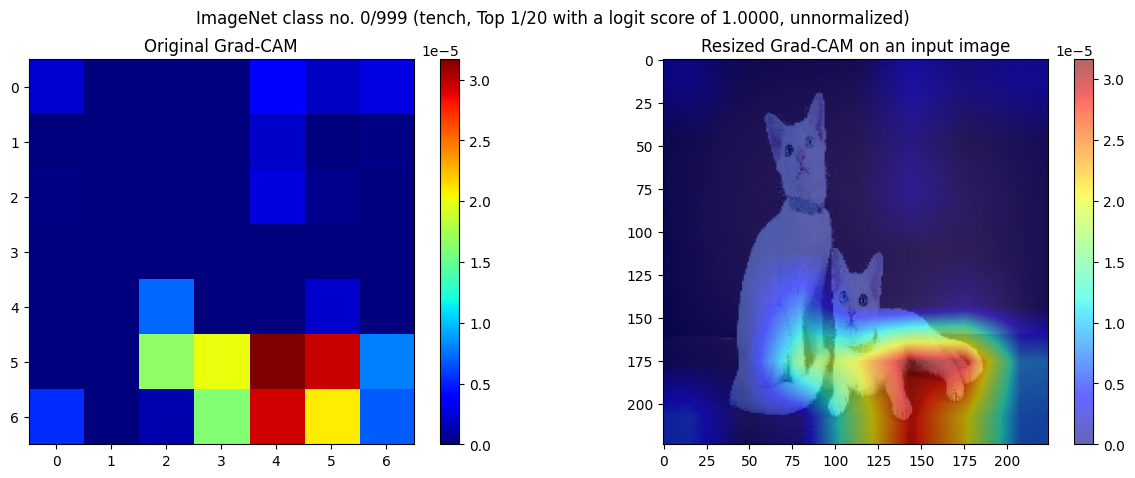

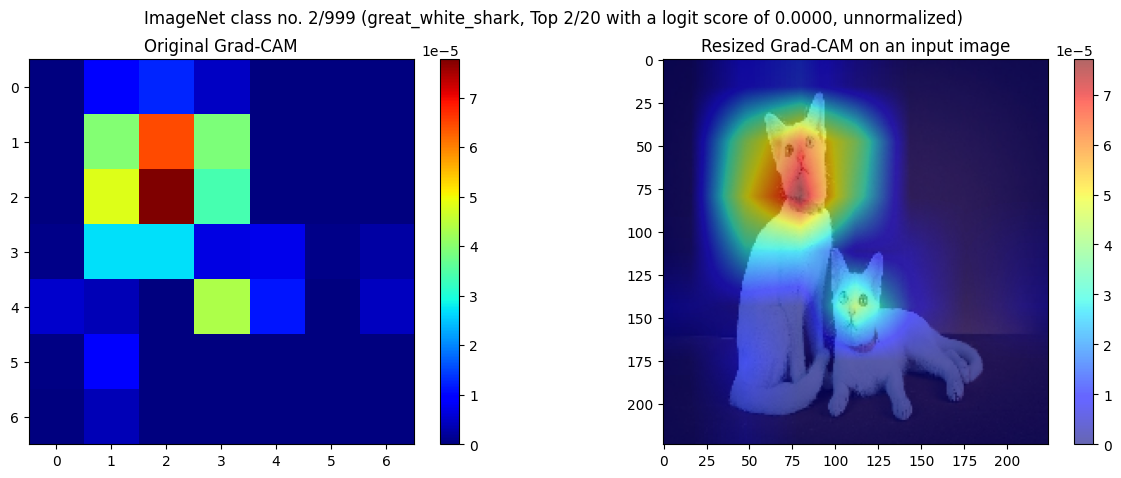

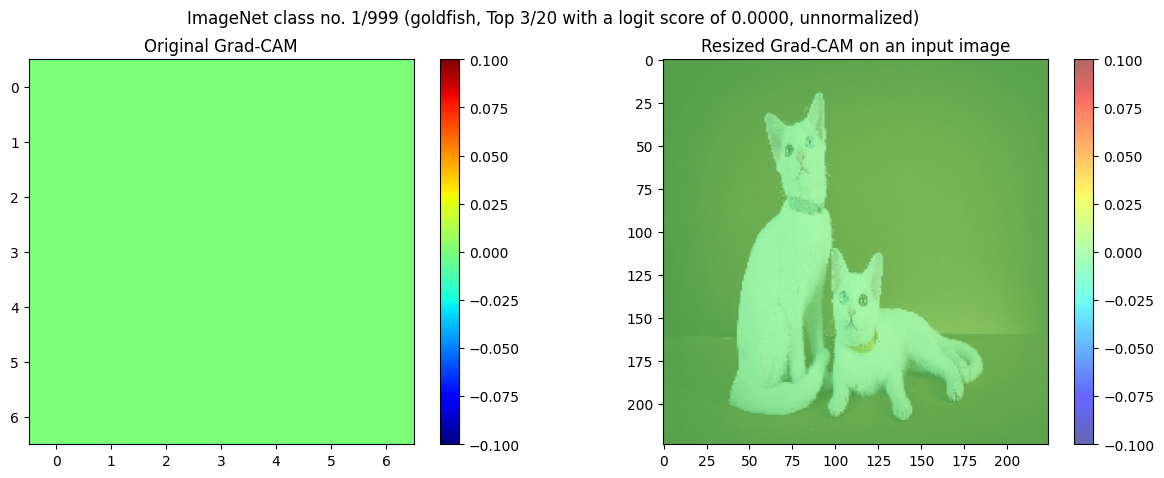

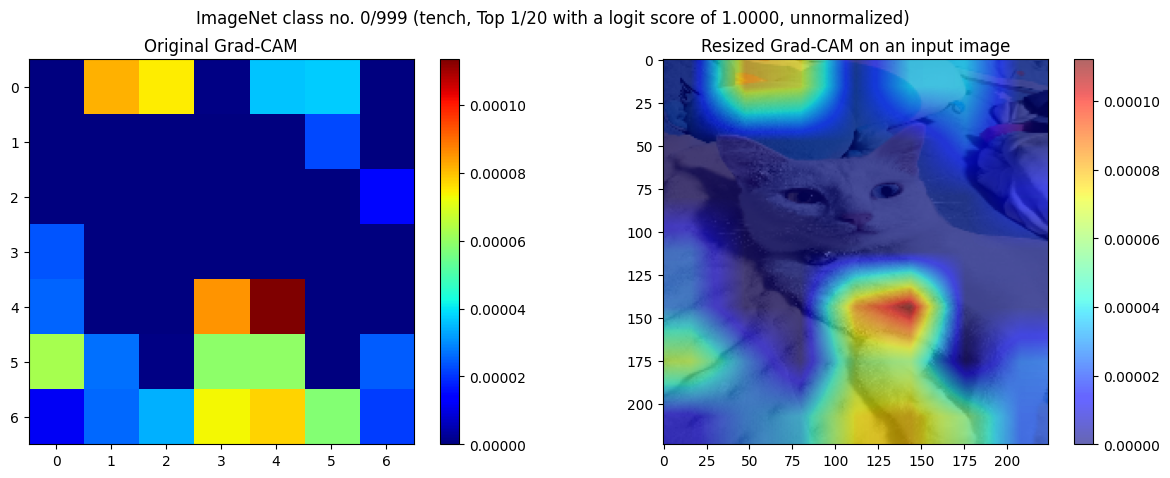

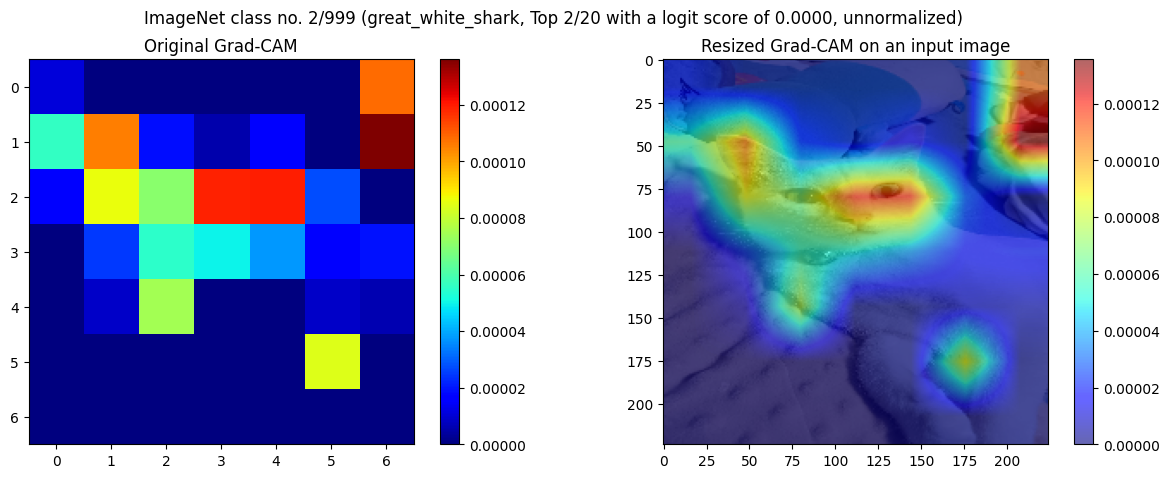

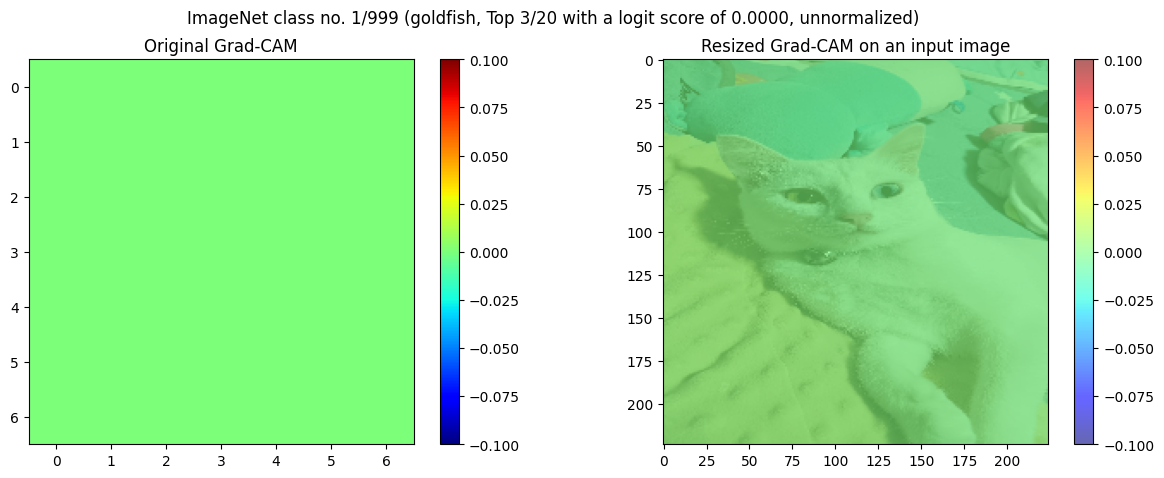

In [ ]:
# Test 'img1' with heatmap_norm=False
visualize_GradCAM_topresult(new_model, img1, img_preprocess1, out_linear1, top=20, heatmap_norm=False)
visualize_GradCAM_topresult(new_model, img2, img_preprocess2, out_linear1, top=20, heatmap_norm=False)

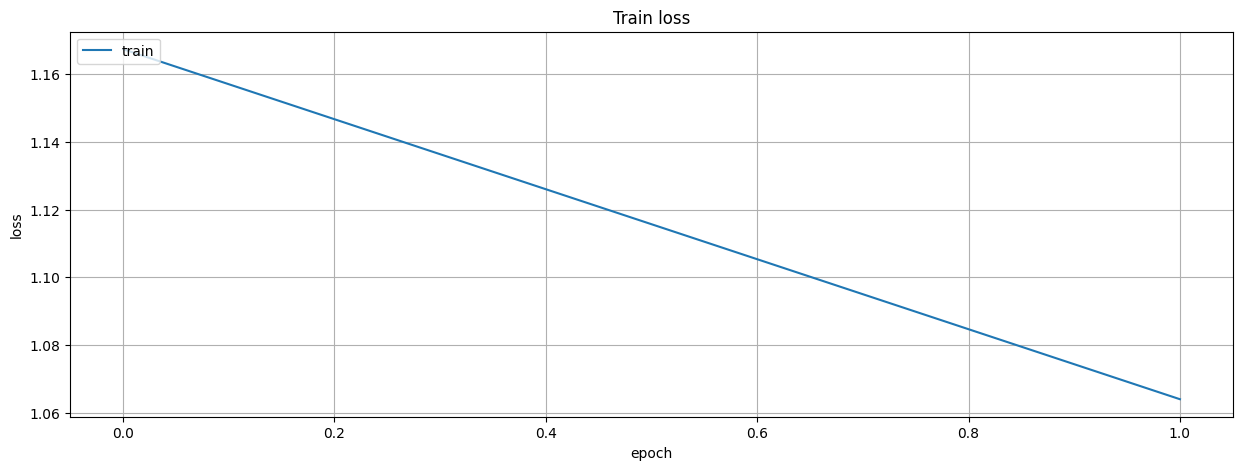

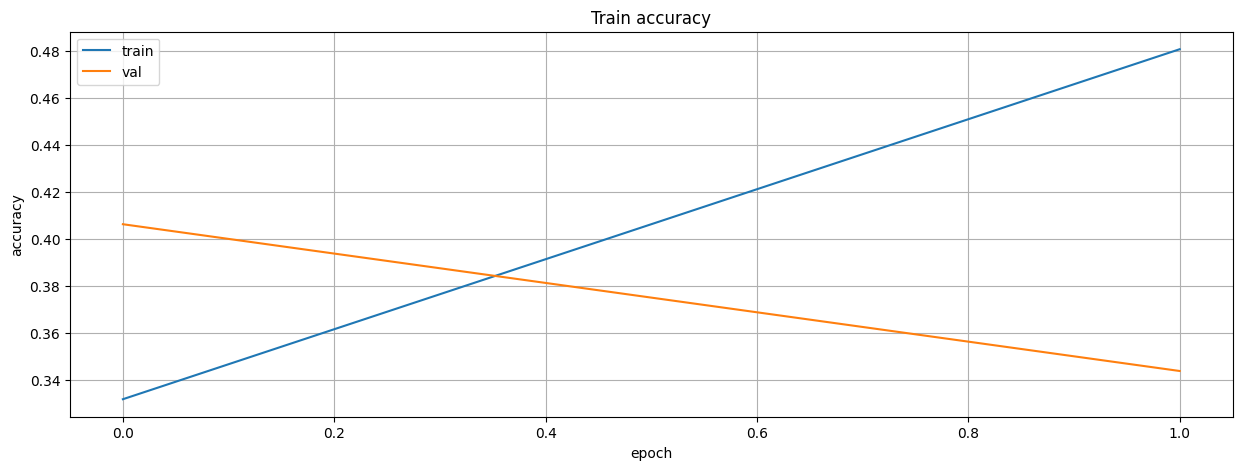

In [ ]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# Load pre-trained model without the top layer
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
num_custom_classes = 3
current_model = models.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D((1, 1)),
    tf.keras.layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_custom_classes, activation='softmax')  # Replace with your number of classes
])
current_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 512)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                 771       
                                                      

In [ ]:
# Compile the model
current_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = current_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=2
)

Epoch 1/2
7/7 [==============================] - 177s 26s/step - loss: 3.3922 - accuracy: 0.4615 - val_loss: 2.0882 - val_accuracy: 0.4688
Epoch 2/2
7/7 [==============================] - 157s 24s/step - loss: 1.7241 - accuracy: 0.5337 - val_loss: 0.8529 - val_accuracy: 0.6875


In [ ]:

# Custom Training loop for Wandb (Not used as we are directly using Callback)
'''for epoch in range(num_epochs):
    # Train the model
    history = current_model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // train_generator.batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // validation_generator.batch_size,
      callbacks=[model_checkpoint_callback]
    )

    # Log metrics to wandb
    wandb.log({
        'model_name': base_model.name,
        'epoch': epoch + 1,
        'train_loss': history.history['loss'][0],
        'train_accuracy': history.history['accuracy'][0],
        'val_loss': history.history['val_loss'][0],
        'val_accuracy': history.history['val_accuracy'][0]
    })'''